# 3.8 커스텀 도구(tool)를 최대한 활용하는 방법

- 2.7 병렬 처리를 통한 효율 개선 (feat. 프롬프트 엔지니어링) 에서 작업한 워크플로우를 에이전트로 변환
- 작성했던 노드(node)들을 도구(tool)로 변환하여 사용합니다
    - 도구(tool)는 고정된 기능을 수행하기 때문에 상태(state)를 활용하지 않는 경우가 많음


In [1]:
from dotenv import load_dotenv

load_dotenv(dotenv_path="../.env")

True

- 도구(tool)을 활용하려면 [`AIMessage`](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.ai.AIMessage.html)를 활용해야하기 때문에 상태에 `messages`가 필요함
- 직접 선언하지 않고 랭그래프에서 제공하는 `MessagesState`를 사용

In [2]:
from langgraph.graph import StateGraph, MessagesState

# class AgentState(MessagesState):
#     pass

# workflow = StateGraph(AgentState)

workflow = StateGraph(MessagesState)

In [3]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma

collection_name = "real_estate_tax"
embedding_funtion = HuggingFaceEmbeddings(model="BAAI/bge-m3")
vector_store = Chroma(
    collection_name=collection_name,
    embedding_function=embedding_funtion,
    persist_directory="./chroma"
)
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

c:\Users\limjangmook\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
query = "5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?"

response = retriever.invoke(query)
print(response[0].page_content)

법제처                                                            4                                                       국가법령정보센터
종합부동산세법
1. 「상속세 및 증여세법」 제16조에 따른 공익법인등(이하 이 조에서 “공익법인등”이라 한다)이 직접 공익목적사업
에 사용하는 주택만을 보유한 경우와 「공공주택 특별법」 제4조에 따른 공공주택사업자 등 사업의 특성을 고려하
여 대통령령으로 정하는 경우: 제1항제1호에 따른 세율
2. 공익법인등으로서 제1호에 해당하지 아니하는 경우: 제1항 각 호에 따른 세율
3. 제1호 및 제2호 외의 경우: 다음 각 목에 따른 세율
가. 2주택 이하를 소유한 경우: 1천분의 27
나. 3주택 이상을 소유한 경우: 1천분의 50
③주택분 과세표준 금액에 대하여 해당 과세대상 주택의 주택분 재산세로 부과된 세액(「지방세법」 제111조제3항
에 따라 가감조정된 세율이 적용된 경우에는 그 세율이 적용된 세액, 같은 법 제122조에 따라 세부담 상한을 적용받
은 경우에는 그 상한을 적용받은 세액을 말한다)은 주택분 종합부동산세액에서 이를 공제한다.<신설 2005. 12. 31.,
2008. 12. 26., 2010. 3. 31.>
④주택분 종합부동산세액을 계산할 때 주택 수 계산 및 주택분 재산세로 부과된 세액의 공제 등에 관하여 필요한
사항은 대통령령으로 정한다.<신설 2005. 12. 31., 2018. 12. 31., 2020. 6. 9.>
⑤ 주택분 종합부동산세 납세의무자가 1세대 1주택자에 해당하는 경우의 주택분 종합부동산세액은 제1항ㆍ제3항
및 제4항에 따라 산출된 세액에서 제6항부터 제9항까지의 규정에 따른 1세대 1주택자에 대한 공제액을 공제한 금
액으로 한다. 이 경우 제6항부터 제9항까지는 공제율 합계 100분의 80의 범위에서 중복하여 적용할 수 있다.<신설
2008. 12. 26., 2018. 12. 31., 2020. 

- [rlm/rag-prompt](https://smith.langchain.com/hub/rlm/rag-prompt)
- HUMAN
    - You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
    - Question: {question} 
    - Context: {context} 
- Answer:

In [5]:
from langchain_ollama import ChatOllama
# 사전 구축된 프롬프트를 사용하기 위해 langchain의 hub 모듈을 임포트
from langchain_classic import hub

llm = ChatOllama(model="llama3.1")

# hub에서 RAG(Retrieval Augmented Generation) 프롬프트 템플릿을 가져옴
rag_prompt = hub.pull("rlm/rag-prompt")

# 문서 포맷팅을 위한 헬퍼 함수
def format_docs(docs):
    """
    여러 문서를 하나의 문자열로 결합하는 포맷팅 함수
    Args:
        docs: page_content를 포함하는 Document 객체 리스트
    Returns:
        str: 줄바꿈으로 구분된 문서 내용을 하나로 합친 문자열
    """
    return "\n\n".join(doc.page_content for doc in docs)

- [How to create tools](https://python.langchain.com/docs/how_to/custom_tools/)
    - Custom 도구(tool)를 활용하려면 `@tool` decorator를 사용함
    - 도구(tool)의 이름(함수이름)과 설명(docstring)을 정의해야함
    - 도구(tool)의 인자를 정의해야함
        - 인자로 사용되는 변수명도 중요함
        - LLM이 Args를 직접 판단해서 도구를 호출하기 때문
    - 도구(tool)의 반환값을 정의해야함  

In [6]:
from langchain_core.tools import tool
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

# 세금 공제액 계산을 위한 커스텀 도구
@tool
def get_tax_deduction(question: str) -> str:
    """사용자의 부동산 소유 현황에 대한 질문을 기반으로 세금 공제액을 계산합니다.
    이 도구는 다음 두 단계로 작동합니다:
    1. tax_deductible_chain을 사용하여 일반적인 세금 공제 규칙을 검색
    2. user_deduction_chain을 사용하여 사용자의 특정 상황에 규칙을 적용
    Args:
        question (str): 부동산 소유에 대한 사용자의 질문
    Returns:
        str: 세금 공제액 (예: '9억원', '12억원')
    """
    print("**** get_tax_deduction ****")
    
    # 공제액 관련 기본 질문 정의
    tax_deduction_question = "주택에 대한 종합부동산세 과세표준의 공제액을 알려주세요"

    # 세금 공제액 정보를 검색하기 위한 체인 구성
    tax_deduction_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | rag_prompt
        | llm
        | StrOutputParser()
    )
  
    # 일반적인 세금 공제 규칙 검색
    tax_deduction_response = tax_deduction_chain.invoke(tax_deduction_question)

    # 사용자별 공제액 계산을 위한 프롬프트 템플릿
    user_deduction_template = """아래 [Context]는 주택에 대한 종합부동산세의 공제액에 관한 내용입니다. 
    사용자의 질문을 통해서 가지고 있는 주택수에 대한 공제액이 얼마인지 설명없이 금액만 반환해주세요
    [Context]: {tax_deduction_response}
    [Question]: {question}
    [Answer]:
    """

    # 프롬프트 템플릿 객체 생성
    user_deduction_prompt = PromptTemplate(
        template=user_deduction_template,
        input_variables=["tax_deduction_response", "question"],
    )

    # 사용자별 공제액 계산을 위한 체인 구성
    user_deduction_chain = (
        user_deduction_prompt
        | llm
        | StrOutputParser()
    )

    # 사용자의 특정 상황에 규칙 적용
    user_deduction_response = user_deduction_chain.invoke({
        "tax_deduction_response": tax_deduction_response,
        "question": question,
    })

    return user_deduction_response

In [7]:
# query = "5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?""

get_tax_deduction.invoke(query)

**** get_tax_deduction ****


'만 60세 이상인 경우는 연령별 공제율이 반영되어야 하는데, 연령별 공제율이 어떻게 적용되는지 설명하지 않고 금액만 반환해드리기 때문에 답변하기 어렵습니다. \n\n하지만 일반적으로 납세의무자가 2주택 이하를 소유한 경우에는 1천분의 27으로 공제되고, 3주택 이상을 소유한 경우는 1천분의 50로 공제됩니다.\n\n이처럼 주택가치에 대한 종합부동산세 공제액은 5억짜리 집 1채에서 2배, 10억짜리 집 1채에서는 3배, 20억짜리 집 1채에서는 4배입니다. \n\n결과적으로, 5억짜리 집 1채는 27%를 공제하고, 10억짜리 집 1채는 50%를 공제합니다. 즉, 같은 가격대의 집이라면 2주택의 경우에는 50%가 더 많이 공제된다는 것입니다.\n\n이에 따라서 합계는 다음과 같습니다.\n- 5억짜리 집 1채: 5400만\n- 10억짜리 집 1채: 6000만\n- 20억짜리 집 1채: 8000만\n\n총 세금은 19400만원입니다.'

In [8]:
# 과세표준 계산을 위한 커스텀 도구 정의
@tool
def get_tax_base() -> str:
    """종합부동산세 과세표준을 계산하기 위한 공식을 검색하고 형식화합니다.
    이 도구는 RAG(Retrieval Augmented Generation) 방식을 사용하여:
    1. 지식 베이스에서 과세표준 계산 규칙을 검색
    2. 검색한 규칙을 수학 공식으로 형식화
    Args:
        question (str): 사용자의 질문 (미리 정의된 질문이 사용됨)
    Returns:
        str: 과세표준 계산 공식
    """
    print("**** get_tax_base ****")

    # 과세표준 계산 방법을 검색하기 위한 표준 질문 정의
    tax_base_question = "주택에 대한 종합부동산세 과세표준을 계산하는 방법은 무엇인가요? 수식으로 표현해서 수식만 반환해주세요"
    
    # 과세표준 정보를 검색하고 처리하기 위한 체인 생성
    # 이 체인은 다음 단계로 실행됨:
    # 1. 질문을 받아 관련 문서를 검색
    # 2. format_docs를 사용하여 문서 포맷팅
    # 3. RAG 프롬프트를 통해 포맷된 컨텍스트와 질문을 처리
    # 4. LLM으로 처리 후 문자열로 파싱
    tax_base_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | rag_prompt
        | llm
        | StrOutputParser()
    )

    # 미리 정의된 질문으로 tax_base_chain을 실행하여 계산 공식 획득
    tax_base_response = tax_base_chain.invoke(tax_base_question)
    
    return tax_base_response

In [9]:
from langchain_community.tools import DuckDuckGoSearchRun
from datetime import datetime

# 현재 공정시장가액비율 검색을 위한 함수
def get_market_value_rate_search():
    """
    현재 연도의 공정시장가액비율을 웹에서 검색합니다.
    Returns:
        str: 현재 공정시장가액비율 정보를 포함한 검색 결과
    """
    # DuckDuckGo 검색 도구 초기화
    search = DuckDuckGoSearchRun()

    return search.invoke(f"{datetime.now().year}년도 공정시장가액비율은?")


# 공정시장가액비율 계산을 위한 커스텀 도구
@tool
def get_market_value_rate(question: str) -> str:
    """사용자의 부동산 상황에 적용되는 공정시장가액비율을 결정합니다.
    이 도구는:
    1. 현재 공정시장가액비율 정보가 포함된 검색 결과를 사용
    2. 사용자의 특정 상황(보유 부동산 수, 부동산 가치)을 분석
    3. 적절한 공정시장가액비율을 백분율로 반환
    Args:
        question (str): 부동산 소유에 대한 사용자의 질문
    Returns:
        str: 공정시장가액비율 백분율 (예: '60%', '45%')
    """
    print("**** get_market_value_rate ****")

    # 공정시장가액비율 추출을 위한 프롬프트 템플릿 정의
    # Context에서 관련 정보를 추출하고 사용자 상황에 맞는 비율을 반환하도록 설계
    market_value_rate_prompt = PromptTemplate.from_template(
        """아래 [Context]는 공정시장가액비율에 관한 내용입니다.
        당신에게 주어진 공정시장가액비율에 관한 내용을 기반으로, 사용자의 상황에 대한 공정시장가액비율을 알려주세요.
        별도의 설명 없이 공정시장가액비율만 반환해주세요.
        [Context]: {context}
        [Question]: {question}
        [Answer]: """)

    # 공정시장가액비율 계산을 위한 체인 구성
    # 프롬프트 -> LLM -> 문자열 파서 순으로 처리
    market_value_rate_chain = (
        market_value_rate_prompt
        | llm
        | StrOutputParser()
    )

    market_value_rate_search = get_market_value_rate_search()

    # 검색된 정보와 사용자 질문을 기반으로 공정시장가액비율 계산
    market_value_rate = market_value_rate_chain.invoke({
        "context": market_value_rate_search,
        "question": question,
    })

    return market_value_rate

In [10]:
# query = "5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?""

get_market_value_rate.invoke(query)

**** get_market_value_rate ****


'45%'

In [11]:
from langchain_core.prompts import ChatPromptTemplate

@tool
def get_house_tax(tax_deduction_question: str, tax_base_question: str, market_value_rate_question: str, question: str) -> str:
    """수집된 모든 정보를 사용하여 최종 종합부동산세액을 계산합니다.
    이 도구는 다음 정보들을 결합하여 최종 세액을 계산합니다:
    1. 과세표준 계산 공식
    2. 공정시장가액비율
    3. 공제액
    4. 세율표
    Args:
        tax_base_question (str): 과세표준 계산 공식
        market_value_rate_question (str): 공정시장가액비율
        tax_deductible_question (str): 공제액
        question (str): 부동산 세금 계산에 대한 사용자의 질문
    Returns:
        str: 설명이 포함된 최종 세금 계산액
    """
    print("**** get_house_tax ****")

    # 세금 계산을 위한 프롬프트 템플릿 생성
    # system 메시지에는 계산에 필요한 기본 정보들을 포함
    system_message = f"""
        과세표준 계산방법: {tax_base_question}
        공정시장가액비율: {market_value_rate_question}
        공제액: {tax_deduction_question}
        위의 공식과 아래 세율에 관한 정보를 활용해서 세금을 계산해 주세요.
        세율: {{tax_rate}} """

    # human 메시지에는 사용자의 질문을 전달
    house_tax_prompt = ChatPromptTemplate.from_messages([
        ("system", system_message),
        ("human", "{question}")
    ])

    # 세금 계산을 위한 체인 구성
    # 1. retriever를 통해 세율 정보를 가져옴
    # 2. 프롬프트에 세율 정보와 질문을 전달
    # 3. LLM으로 계산 수행
    # 4. 결과를 문자열로 변환
    house_tax_chain = (
        {
            "tax_rate": retriever | format_docs,  # 벡터 DB에서 세율 정보 검색
            "question": RunnablePassthrough(),    # 사용자 질문 그대로 전달
        }
        | house_tax_prompt    # 프롬프트 템플릿에 정보 전달
        | llm                 # LLM으로 계산 수행
        | StrOutputParser()   # 결과를 문자열로 변환
    )

    # 체인 실행하여 최종 세금 계산 결과 반환
    house_tax = house_tax_chain.invoke(question)

    return house_tax

- `node`를 추가하고 `edge`로 연결합니다
- 하나의 `node`에서 `edge`를 활영해서 다양한 `node`들을 연결하면 병렬로 작업이 가능합니다

In [12]:
from langgraph.prebuilt import ToolNode

tools = [get_tax_deduction, get_tax_base, get_market_value_rate, get_house_tax]
tool_node = ToolNode(tools=tools)

llm_with_tools = llm.bind_tools(tools=tools)

In [13]:
from langchain_core.messages import SystemMessage

def agent(state: MessagesState) -> MessagesState:
    """
    에이전트 함수는 주어진 상태에서 메시지를 가져와 LLM과 도구를 사용하여 응답 메시지를 생성합니다.
    Args:
        state (MessagesState): 메시지 상태를 포함하는 state.
    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    """
    print("**** agent ****")

    system_message = """
        당신의 역할은 주택에 대한 종합부동산세를 계산하는 것입니다. 
        사용자의 질문이 들어오면, 사용자의 질문을 바탕으로 종합부동산세를 계산해주세요.
        종합부동산세를 계산하기 위해서는 과세표준을 어떻게 계산할지 파악해야하고, 
        사용자에 질문에 따른 공제액을 파악해야 하고, 
        사용자에 질문에 따른 공정시장가액비율을 파악해야 합니다.
        이 세가지를 파악하고 나면, 종합부동산세를 계산해주세요.
        """
    messages = [SystemMessage(content=system_message)] + state["messages"]
    response = llm_with_tools.invoke(messages)
    
    return {"messages": [response]}

In [14]:
from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition

workflow.add_node(agent)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", tools_condition)
workflow.add_edge("tools", "agent")

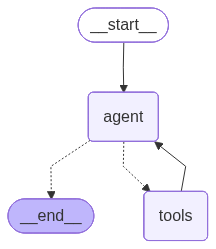

In [15]:
graph = workflow.compile()
graph

In [16]:
from langchain_core.messages import HumanMessage

query = "5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?"

for response in graph.stream({"messages": [HumanMessage(query)]}, stream_mode="values"):
    response["messages"][-1].pretty_print()

================================ Human Message =================================

5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?
**** agent ****
================================== Ai Message ==================================
Tool Calls:
  get_house_tax (d513639a-d721-4f8b-ba2d-2a924ddf091d)
 Call ID: d513639a-d721-4f8b-ba2d-2a924ddf091d
  Args:
    market_value_rate_question: get_market_value_rate
    question: 5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?
    tax_base_question: get_tax_base
    tax_deductible_question: get_tax_deduction
================================= Tool Message =================================
Name: get_house_tax

Error invoking tool 'get_house_tax' with kwargs {'market_value_rate_question': 'get_market_value_rate', 'question': '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?', 'tax_base_question': 'get_tax_base', 'tax_deductible_question': 'get_tax_deduction'} with error:
 tax_deduction_question: Field required
 Please fix the err